In [2]:
import errno
import os

import freud
import gsd
import gsd.hoomd
import gsd.pygsd
import hoomd
import hoomd.md
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter

import ex_render
from ibi import IBI

%matplotlib inline
plt.rcParams.update({"font.size": 16})
%load_ext autoreload
%autoreload 2


def lj_potential(r, eps=1, sig=1):
    return 4 * eps * ((sig / r) ** 12 - (sig / r) ** 6)


dir_name = "msibi_output"

try:
    os.mkdir(dir_name)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Step through msibi

giving it a try with the ibi class

Iteration # 0


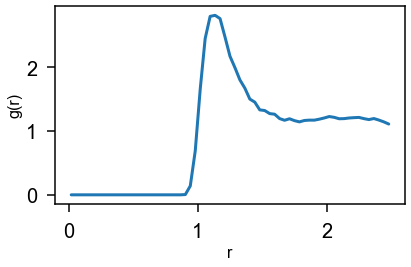

ValueError: The number of derivatives at boundaries does not match: expected 2, got 0+0

In [3]:
from ibi import IBI


ibi = IBI()

last = 10
pot_file = None

for iteration in range(last):
    print(f"Iteration # {iteration}")
    # This is just so we don't have to run the LJ init each time.
    if iteration != 0:
        logfile, gsdfile = ibi.run_hoomd(run_steps=2e4, pot_file=pot_file)
    else:
        gsdfile = f"{dir_name}/trajectory-{iteration}.gsd"
        
    rdf = ibi.gsd_rdf(gsdfile, rmax=2.5)
    
    plt.plot(rdf.bin_centers, rdf.rdf)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.show()
    
    v_array = ibi.get_table_potential(rdf, smooth=True, plot=True)
    #plt.ylim((-4,2))
    plt.show()

    pot_file = f"{dir_name}/v{iteration}.dat"
    np.savetxt(pot_file, v_array, header="r  V  F")
    if iteration == 0:
        ibi.vstar = v_array[:,1]
    
    ibi.vprev = v_array[:,1]
    
    ibi.iteration += 1


In [7]:
## Example of how force/potential smoothing could work (not used)
#
#f_min = min(v_array[:,2])
#f_min_ind = np.where(v_array[:,2]==f_min)[0][0]
#
#ones = np.ones(f_min_ind)
## sigmoid smoothing function
#decrease = -1/(1+np.exp(-5*np.linspace(-1,1,len(v_array[f_min_ind:,2]))))+1
#smoothing_arr = np.concatenate((ones,decrease))
#
#plt.plot(v_array[:,0], smoothing_arr, label="smoothing array")
#plt.plot(v_array[:,0], smoothing_arr * v_array[:,2], label="smoothed F(r)")
#plt.plot(v_array[:,0], v_array[:,2], label="F(r)")
#plt.legend()
#plt.ylim((-3.5,2))
#plt.show()